In [1]:
# Copyright (C) 2020-2021  Mael Kerbiriou <piezo.wdimd@gmail.com>
#
# This file may be distributed under the terms of the GNU GPLv3 license.
from contextlib import contextmanager
import numpy as np
from matplotlib import pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')
plt.style.use(['dark_background'])

plt_kwargs = dict(
    toolhead=dict(color=(.5,.5,1), zorder=20),
    X=dict(color='red'),
    Y=dict(color=(.0,.8,.0)),
    A=dict(color='cyan'),
    B=dict(color='yellow'),
    )
for k in plt_kwargs: plt_kwargs[k]['linewidth'] = 1.25
plt_kwargs['toolhead']['linewidth'] = 3

@contextmanager
def fig_tmpl(title, ordinate):
    f = plt.figure(figsize=(10,5))
    plt.grid(False)
    plt.title(title)
    plt.xlabel('Move orientation (°)')
    plt.ylabel('Max %s (relative)' % ordinate)
    plt.xticks(np.linspace(0,180,4*3, endpoint=False))
    try:
        yield f
    finally:
        _, ymax = plt.ylim()
        plt.ylim((0,ymax))
        plt.xlim((0,180))

        plt.legend(loc='lower right')
        plt.tight_layout()
        
def gen_moves(theta):
    d = np.random.rand(*theta.shape)*10+1 # Random move lengths
    return d*np.cos(theta), d*np.sin(theta)

theta = np.linspace(0,np.pi, 256)
theta_deg = (180/np.pi) * theta
x,y = gen_moves(theta)
d = np.hypot(x,y)

## Cartesian

### Velocitiy limits

When the toolhead on a cartesian printer moves at a constant speed, each independant axis might move at a lower speed depending on the orientation. The following graph shows axes velocities for a constant toolhead speed at each move orientation:

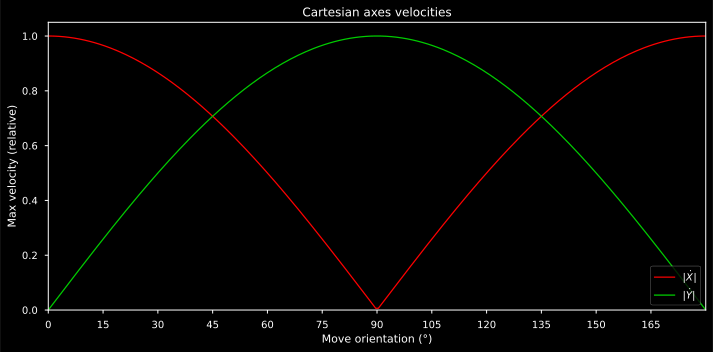

In [2]:
v_x, v_y = x / d, y / d

with fig_tmpl('Cartesian axes velocities', 'velocity'):
    plt.plot(theta_deg, np.abs(v_x), label='$|\dot X|$', **plt_kwargs['X'])
    plt.plot(theta_deg, np.abs(v_y), label='$|\dot Y|$', **plt_kwargs['Y'])

This is simply $|\cos \theta|$ and $|\sin \theta|$. Notice that, at 45° and 135° degree, the axes moves at $1/\sqrt 2 = 70.7\%$ the speed of the toolhead.

The main role of speed limits is to avoid reaching the step frequencies where the pull-out torque of steppers drops drastically. In Klipper upstream, `max_velocity` is defined in the toolhead space, independent of the orienatation of displacement and printer kinematic.

The next graph shows what happens if we instead limit the velocities at the axes. At an angle of 45°, both motors runs at $v_\text{max}$, yielding a combined toolhead speed of $\sqrt{2}\cdot v_\text{max}$:

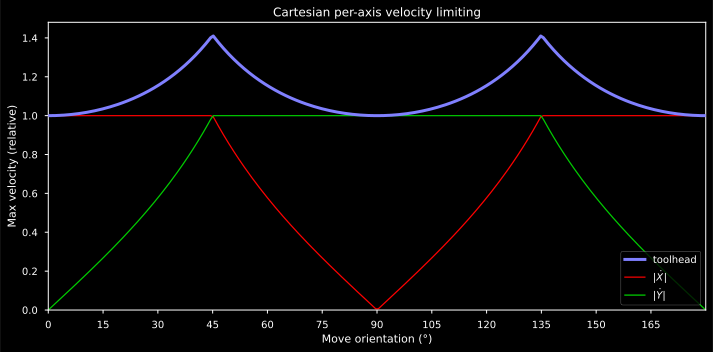

In [3]:
max_vel = 1
#max_vel = np.minimum(max_vel*d/np.abs(x), max_vel*d/np.abs(y))
max_vel = max_vel * d / np.maximum(np.abs(x), np.abs(y))
v_x, v_y = max_vel * x / d, max_vel * y / d

with fig_tmpl('Cartesian per-axis velocity limiting', 'velocity'):
    plt.plot(theta_deg, max_vel, label='toolhead', **plt_kwargs['toolhead'])
    plt.plot(theta_deg, np.abs(v_x), label='$|\dot X|$', **plt_kwargs['X'])
    plt.plot(theta_deg, np.abs(v_y), label='$|\dot Y|$', **plt_kwargs['Y'])

### Acceleration limits

On most printers, like bed slingers and h-bots, one axis is heavier and require more torque to accelerate. To work closer to the machine limits, it is desirable to restrict the acceleration on the heaviest axis (often Y).

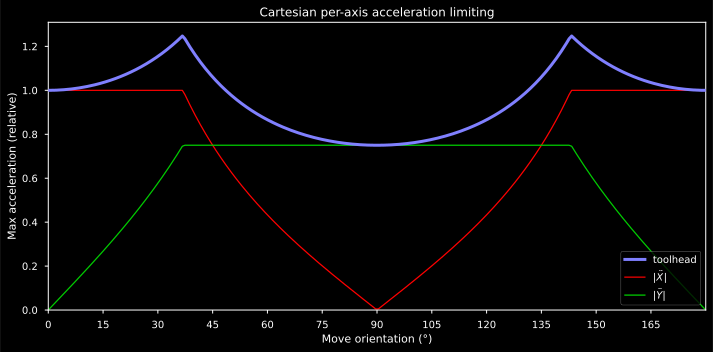

In [4]:
max_acc_x = 1
max_acc_y = 0.75
max_acc = d/np.maximum(np.abs(x)/max_acc_x, np.abs(y)/max_acc_y)
v_x, v_y = max_acc * x / d, max_acc * y / d

with fig_tmpl('Cartesian per-axis acceleration limiting', 'acceleration'):
    plt.plot(theta_deg, max_acc, label='toolhead', **plt_kwargs['toolhead'])
    plt.plot(theta_deg, np.abs(v_x), label='$|\ddot X|$', **plt_kwargs['X'])
    plt.plot(theta_deg, np.abs(v_y), label='$|\ddot Y|$', **plt_kwargs['Y'])

The angle with maximum acceleration is given by $\arctan \frac{a_{max,Y}}{a_{max,X}}$ ($\simeq 37°$ here with $a_{max,Y}=3/4 \times a_{max,X}$).

It might be a good idea to limit the velocities with the same axis-to-axis ratio than acceleration. This allows the tapezoidal profiles to have the same shape independantly of move orientation. The [smoothed look-ahead](https://www.klipper3d.org/Kinematics.html#smoothed-look-ahead) will acheive the same thing since the top speed depends on acceleration, but only on short moves.

## CoreXY

[CoreXY](http://corexy.com/theory.html) uses a different belt path allowing the motors to stay stationnary. The forward and reverse kinmatics are:

$$
\begin{cases}
2X = A + B \\ 
2Y = A - B \\ 
\end{cases}
$$

$$
\begin{cases}
A = X + Y \\ 
B = X - Y \\ 
\end{cases}
$$ $A$ and $B$ designate the actuators.

Since these relations are linear, the equations works equaly for position, velocity and acceleration.

### Velocity limits

A constant velocity toollhead displacement $v$ requires belt velocites of up to $\sqrt{2}\cdot v$:

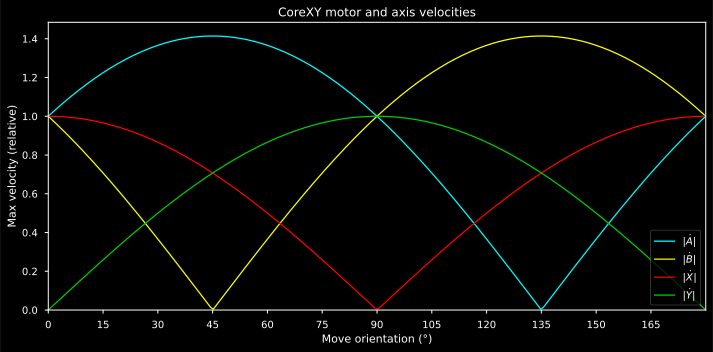

In [5]:
v_x, v_y = x / d, y / d
v_a, v_b = v_x + v_y, v_x - v_y

with fig_tmpl('CoreXY motor and axis velocities', 'velocity'):
    plt.plot(theta_deg, np.abs(v_a), label='$|\dot A|$', **plt_kwargs['A'])
    plt.plot(theta_deg, np.abs(v_b), label='$|\dot B|$', **plt_kwargs['B'])
    plt.plot(theta_deg, np.abs(v_x), label='$|\dot X|$', **plt_kwargs['X'])
    plt.plot(theta_deg, np.abs(v_y), label='$|\dot Y|$', **plt_kwargs['Y'])

Limiting the motor velocities will decrease the toolhead velocities with minimums at 45° and 135°:

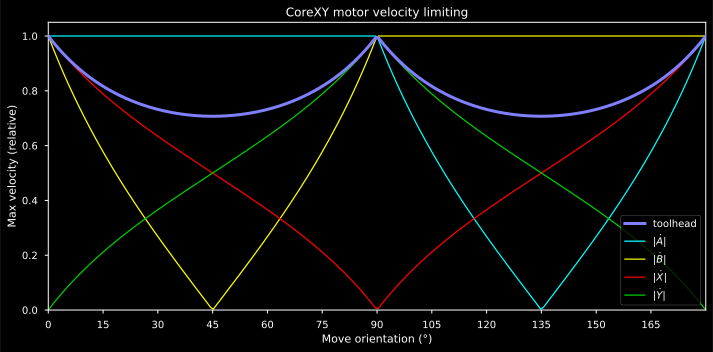

In [6]:
max_vel = 1

max_vel = max_vel*d/np.maximum(np.abs(x+y), np.abs(x-y))
v_x, v_y = max_vel * x / d, max_vel * y / d
v_a, v_b = v_x + v_y, v_x - v_y


with fig_tmpl('CoreXY motor velocity limiting', 'velocity'):
    plt.plot(theta_deg, max_vel, label='toolhead', **plt_kwargs['toolhead'])
    plt.plot(theta_deg, np.abs(v_a), label='$|\dot A|$', **plt_kwargs['A'])
    plt.plot(theta_deg, np.abs(v_b), label='$|\dot B|$', **plt_kwargs['B'])
    plt.plot(theta_deg, np.abs(v_x), label='$|\dot X|$', **plt_kwargs['X'])
    plt.plot(theta_deg, np.abs(v_y), label='$|\dot Y|$', **plt_kwargs['Y'])

Unlike cartesian, the motor velocities on CoreXY match the toolhead velocity when the max speed is acheived (at 0° and 90° orientation). However, in practive limiting motor velocity yields, again, a potential 41% increase of top speed, compared to just limiting the toolhead velocity.

### Torque limiting

On cartesian printer, acceleration is a direct proxy for torque because each moving mass accelerate on it own independant axis. This is no longer true for CoreXY where effefct of inertia felt by the motor working against each other depend on the orientation. The forces exerced on the toolhead are related to the accelerations:

$$
\begin{cases}
F_X = m_X a_X \\ 
F_Y = m_Y a_Y \\ 
\end{cases}
$$

where

$$
\begin{cases}
m_X = m_\text{toolhead} \\
m_Y = m_\text{toolhead} + m_\text{gantry}
\end{cases}
$$

On the belts, at the motors, we get the forces:

$$
\begin{cases}
F_A = m_X a_X + m_Y a_Y \\ 
F_B = m_Y a_Y - m_Y a_Y \\ 
\end{cases}
$$

The following graph shows forces for unitary acceleration and masses $m_\text{toolhead}=1$, $m_\text{gantry}=2/3$:

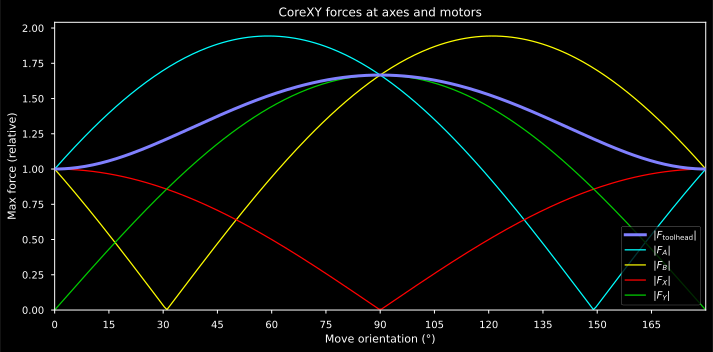

In [7]:
m_toolhead = 1
m_gantry = 2/3
m_x = m_toolhead
m_y = m_toolhead + m_gantry

a_x = x / d
a_y = y / d

f_x = m_x * a_x
f_y = m_y * a_y
f = np.hypot(f_x, f_y)

f_a = f_x + f_y
f_b = f_x - f_y

with fig_tmpl('CoreXY forces at axes and motors', 'force'):
    plt.plot(theta_deg, f, label=r'$|F_\mathrm{toolhead}|$', **plt_kwargs['toolhead'])
    plt.plot(theta_deg, np.abs(f_a), label='$|F_A|$', **plt_kwargs['A'])
    plt.plot(theta_deg, np.abs(f_b), label='$|F_B|$', **plt_kwargs['B'])
    plt.plot(theta_deg, np.abs(f_x), label='$|F_X|$', **plt_kwargs['X'])
    plt.plot(theta_deg, np.abs(f_y), label='$|F_Y|$', **plt_kwargs['Y'])

Given the normed orientation vector $ [ r_X \; r_Y ] = [\Delta X \; \Delta Y] / \sqrt{\Delta X^2 + \Delta Y^2}$, we can make the toolhead acceleration appear:

$$
\begin{cases}
F_A = a (m_X r_X + m_Y r_Y) \\ 
F_B = a (m_Y r_Y - m_Y r_Y) \\ 
\end{cases}
$$

Allowing to compute the maxium acceleration for the given force limit $F_\text{max}$ (supposed equal on both motors):


$$
\begin{align}
a_\text{max} &= \min \left( \frac{F_\text{max}}{|m_X r_X + m_Y r_Y|},\, \frac{F_\text{max}}{|m_X r_X - m_Y r_Y|} \right) \\
    &= \frac{ F_\text{max} }{ \max \left( |m_X r_X + m_Y r_Y|,\, |m_X r_X - m_Y r_Y| \right) } \\
    &= \frac{ F_\text{max} \sqrt{\Delta X^2 + \Delta Y^2} }
            { \max \left( |m_X \Delta X + m_Y \Delta Y|,\, |m_X \Delta X - m_Y \Delta Y| \right) }
\end{align}
$$

Here is the maximum accelerations we get, limiting the forces to 1:

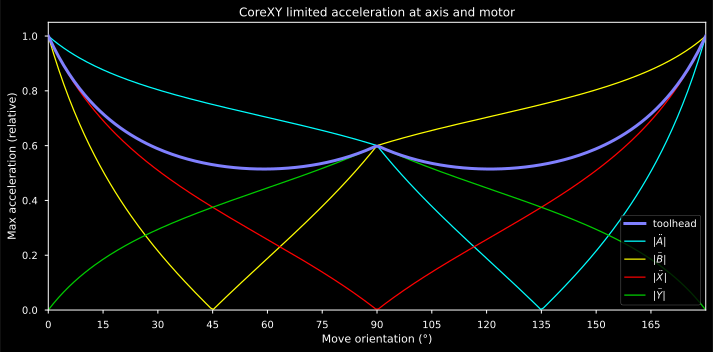

In [8]:
f_max = 1
m_x = 1
m_y = m_x + 2/3

r_x = x / d
r_y = y / d

#a = np.minimum(f_max / np.abs(m_x * r_x + m_y * r_y), f_max / np.abs(m_x * r_x - m_y * r_y))
#a = f_max / np.maximum(np.abs(m_x * r_x + m_y * r_y), np.abs(m_x * r_x - m_y * r_y))
#a = f_max * d / np.maximum(np.abs(m_x * x + m_y * y), np.abs(m_x * x - m_y * y))
amax_x = f_max / m_x
amax_y = f_max / m_y
a = d / np.maximum(np.abs(x / amax_x + y / amax_y), np.abs(x / amax_x - y / amax_y))

a_x = a * r_x
a_y = a * r_y

a_a = a_x + a_y
a_b = a_x - a_y

with fig_tmpl('CoreXY limited acceleration at axis and motor', 'acceleration') as f:
    plt.plot(theta_deg, a, label='toolhead', **plt_kwargs['toolhead'])
    plt.plot(theta_deg, np.abs(a_a), label='$|\ddot A|$', **plt_kwargs['A'])
    plt.plot(theta_deg, np.abs(a_b), label='$|\ddot B|$', **plt_kwargs['B'])
    plt.plot(theta_deg, np.abs(a_x), label='$|\ddot X|$', **plt_kwargs['X'])
    plt.plot(theta_deg, np.abs(a_y), label='$|\ddot Y|$', **plt_kwargs['Y'])

Here is again the forces on the belts at the motors, checking that they are indeed limited:

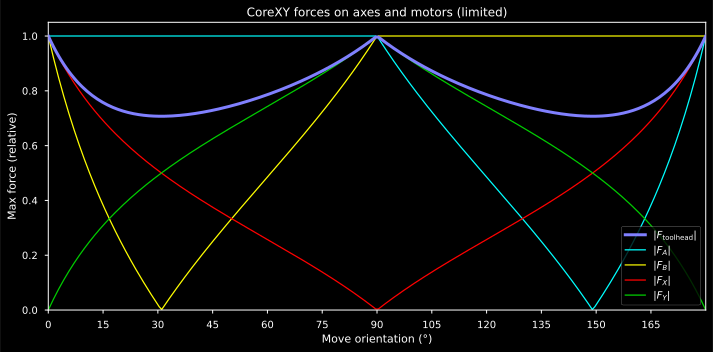

In [9]:
f_x = m_x * a_x
f_y = m_y * a_y
f = np.hypot(f_x, f_y)

f_a = f_x + f_y
f_b = f_x - f_y

with fig_tmpl('CoreXY forces on axes and motors (limited)', 'force'):
    plt.plot(theta_deg, f, label=r'$|F_\mathrm{toolhead}|$', **plt_kwargs['toolhead'])
    plt.plot(theta_deg, np.abs(f_a), label='$|F_A|$', **plt_kwargs['A'])
    plt.plot(theta_deg, np.abs(f_b), label='$|F_B|$', **plt_kwargs['B'])
    plt.plot(theta_deg, np.abs(f_x), label='$|F_X|$', **plt_kwargs['X'])
    plt.plot(theta_deg, np.abs(f_y), label='$|F_Y|$', **plt_kwargs['Y'])


#### Settings

One possibility for configuration, is to let the user set their nominal torque, and masses for toolheand and gantry. The maximum force would then be computed from `rotation_distance` and `gear_ratio`.

Alternatively it is possible to rewrite the $a_\text{max}$ acceleration like this:
$$
\begin{align}
a_\text{max} &= \frac{ F_\text{max} }{ \max \left( |m_X r_X + m_Y r_Y|,\, |m_X r_X - m_Y r_Y| \right) } \\
\frac{1}{a_\text{max}}  
  &= \max \left( 
       \left| \frac{m_X}{F_\text{max}} r_X + \frac{m_Y}{F_\text{max}} r_Y \right|,\, 
       \left| \frac{m_X}{F_\text{max}} r_X - \frac{m_Y}{F_\text{max}} r_Y \right|
    \right)  \\
  &= \max \left( 
       \left| \frac{r_X}{\tilde{a}_X} + \frac{r_Y}{\tilde{a}_Y} \right|,\, 
       \left| \frac{r_X}{\tilde{a}_X} - \frac{r_Y}{\tilde{a}_Y} \right|
    \right)
\end{align}
$$

where $\tilde{a}_X$ and $\tilde{a}_Y$ are (pseudo?)-acceleration on X and Y axes.

The settings used above ($m_X=1$, $m_Y=5/3$ and $F_\text{max}=1$) are equivelent to $\tilde{a}_X=1$ and $\tilde{a}_Y=0.6$ which correspond to the toolhead accelerations when the movement is aligned with one or the other axis.

This is more WYSIWYG and uses one setting value less, so it's probebly better.